In [ ]:
pip install pymoo


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 49.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.0 MB/s eta 0:00:00
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210082 sha256=23c0aace167aa77abcf3885ff948a6845a295369331681bcf3e71530414628bf
  Stored in directory: /root/.cache/pip/wheels/ee/3b/0b/1b865800e916d671a24028d884698674138632a83fdfad4926
Successfully built grapheme


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |      5 |             - |             -
     2 |       60 |      7 |  0.0397040769 |             f
     3 |       90 |      9 |  0.0217949821 |             f
     4 |      120 |     19 |  0.0150611535 |             f
     5 |      150 |     23 |  0.0047628972 |         ideal
     6 |      180 |     30 |  0.0372127673 |         ideal
     7 |      210 |     30 |  0.0048273547 |             f
     8 |      240 |     30 |  0.0456038913 |         ideal
     9 |      270 |     30 |  0.0254375724 |         ideal
    10 |      300 |     30 |  0.0064239736 |         ideal
    11 |      330 |     30 |  0.0193543497 |         ideal
    12 |      360 |     30 |  0.0333655431 |         ideal
    13 |      390 |     30 |  0.0141172555 |         ideal
    14 |      420 |     30 |  0.0149630368 |         ideal
    15 |      450 |     30 |  0.0021586974 |             f
    16 |      480 |     30 |  0.0074015835 |            

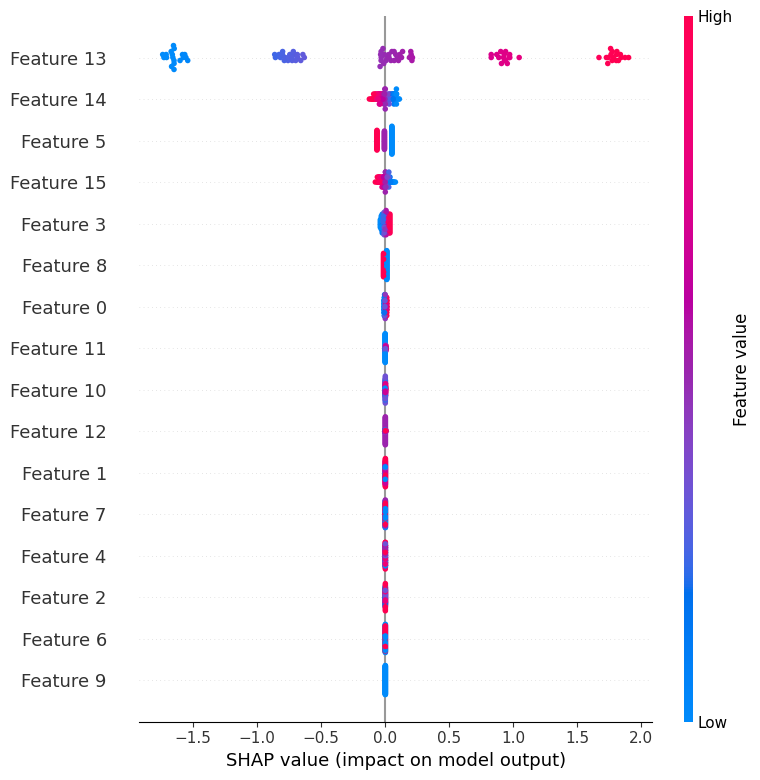

In [ ]:
# ------------------ 🚀 Import Required Libraries ------------------
import pandas as pd
import numpy as np
import optuna
import networkx as nx
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

# ✅ Correct pymoo Imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination

# ------------------ 🚀 Load & Preprocess Data ------------------
df = pd.read_csv("VRPE_1000.csv")

# Encode categorical variables properly
categorical_features = ['Gender', 'Field_of_Study', 'Subject', 'Instructor_VR_Proficiency',
                        'Access_to_VR_Equipment', 'Collaboration_with_Peers_via_VR']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numeric
    label_encoders[col] = le  # Store encoders for later use if needed

# Convert entire DataFrame to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# ------------------ 🚀 Feature Engineering ------------------
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['Field_of_Study'], row['Subject'], weight=row['Engagement_Level'])

df['Study_Centrality'] = df['Field_of_Study'].map(nx.degree_centrality(G))
df['Engagement_Trend'] = df['Engagement_Level'].rolling(window=3, min_periods=1).mean()
df['Instructor_Impact'] = df['Instructor_VR_Proficiency'] * df['Engagement_Level']
df['VR_Usage_Stress'] = df['Hours_of_VR_Usage_Per_Week'] * df['Stress_Level_with_VR_Usage']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
pca_features = pca.fit_transform(df[['Age', 'Hours_of_VR_Usage_Per_Week', 'Engagement_Level',
                                     'Collaboration_with_Peers_via_VR', 'Instructor_VR_Proficiency']])
df[['PCA_1', 'PCA_2', 'PCA_3']] = pca_features

# Define Features and Targets
feature_cols = ['Age', 'Gender', 'Field_of_Study', 'Hours_of_VR_Usage_Per_Week', 'Subject',
                'Instructor_VR_Proficiency', 'Access_to_VR_Equipment', 'Stress_Level_with_VR_Usage',
                'Collaboration_with_Peers_via_VR', 'Study_Centrality', 'Engagement_Trend',
                'Instructor_Impact', 'VR_Usage_Stress', 'PCA_1', 'PCA_2', 'PCA_3']

X = df[feature_cols]
y_engagement = df['Engagement_Level']
y_learning = df['Improvement_in_Learning_Outcomes']

# Train-Test Split
X_train, X_test, y_train_eng, y_test_eng = train_test_split(X, y_engagement, test_size=0.2, random_state=42)
X_train, X_test, y_train_learn, y_test_learn = train_test_split(X, y_learning, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------ 🚀 Multi-Objective Optimization with NSGA-II ------------------
class SVM_Optimization(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=[1e-2, 1e-2, 0], xu=[1e2, 1, 2])

    def _evaluate(self, x, out, *args, **kwargs):
        C, epsilon, kernel_idx = x
        kernel = ["linear", "rbf", "poly"][int(kernel_idx)]

        model_eng = SVR(C=C, epsilon=epsilon, kernel=kernel)
        model_learn = SVR(C=C, epsilon=epsilon, kernel=kernel)

        score_eng = -np.mean(cross_val_score(model_eng, X_train, y_train_eng, cv=5, scoring="neg_mean_absolute_error"))
        score_learn = -np.mean(cross_val_score(model_learn, X_train, y_train_learn, cv=5, scoring="neg_mean_absolute_error"))

        out["F"] = [score_eng, score_learn]

problem = SVM_Optimization()
algorithm = NSGA2(pop_size=30, sampling=FloatRandomSampling(), crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(prob=0.2, eta=20), eliminate_duplicates=True)

res = minimize(problem, algorithm, get_termination("n_gen", 30), seed=42, verbose=True)

# Best hyperparameters from NSGA-II
best_C, best_epsilon, best_kernel_idx = res.X[0]
best_kernel = ["linear", "rbf", "poly"][int(best_kernel_idx)]

# Train Optimized SVM Models
svm_eng = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel)
svm_learn = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel)

svm_eng.fit(X_train, y_train_eng)
svm_learn.fit(X_train, y_train_learn)

# Predictions
y_pred_eng = svm_eng.predict(X_test)
y_pred_learn = svm_learn.predict(X_test)

# ------------------ 🚀 Performance Evaluation ------------------
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    variance_true = np.var(y_true)
    variance_pred = np.var(y_pred)
    covariance = np.cov(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
    ccc = (2 * covariance) / (variance_true + variance_pred + (mean_true - mean_pred) ** 2 + 1e-9)
    return ccc

# Engagement Metrics
engagement_mae = mean_absolute_error(y_test_eng, y_pred_eng)
engagement_rmse = np.sqrt(mean_squared_error(y_test_eng, y_pred_eng))
engagement_mape = np.mean(np.abs((y_test_eng - y_pred_eng) / (y_test_eng + 1e-9))) * 100
engagement_r2 = r2_score(y_test_eng, y_pred_eng)
engagement_ccc = concordance_correlation_coefficient(y_test_eng, y_pred_eng)

# Learning Metrics
learning_mae = mean_absolute_error(y_test_learn, y_pred_learn)
learning_rmse = np.sqrt(mean_squared_error(y_test_learn, y_pred_learn))
learning_mape = np.mean(np.abs((y_test_learn - y_pred_learn) / (y_test_learn + 1e-9))) * 100
learning_r2 = r2_score(y_test_learn, y_pred_learn)
learning_ccc = concordance_correlation_coefficient(y_test_learn, y_pred_learn)

# ------------------ 🚀 SHAP Analysis ------------------
explainer = shap.Explainer(svm_eng, X_test[:100])  # Use a sample
shap.summary_plot(explainer(X_test[:100]), X_test[:100])


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      8 |             - |             -
     2 |      100 |     10 |  0.0133479405 |         ideal
     3 |      150 |     13 |  0.0233645402 |         ideal
     4 |      200 |     22 |  0.0050427245 |         ideal
     5 |      250 |     29 |  0.0808762455 |         nadir
     6 |      300 |     32 |  0.0441400448 |         nadir
     7 |      350 |     46 |  0.0054233485 |             f
     8 |      400 |     50 |  0.0023892811 |             f
     9 |      450 |     50 |  0.0200297180 |         nadir
    10 |      500 |     50 |  0.0028529947 |             f
    11 |      550 |     50 |  0.0029381707 |             f
    12 |      600 |     49 |  0.0251403507 |         nadir
    13 |      650 |     50 |  0.0277984721 |         nadir
    14 |      700 |     50 |  0.0028924663 |             f
    15 |      750 |     50 |  0.0309617941 |         nadir
    16 |      800 |     50 |  0.0016730349 |            

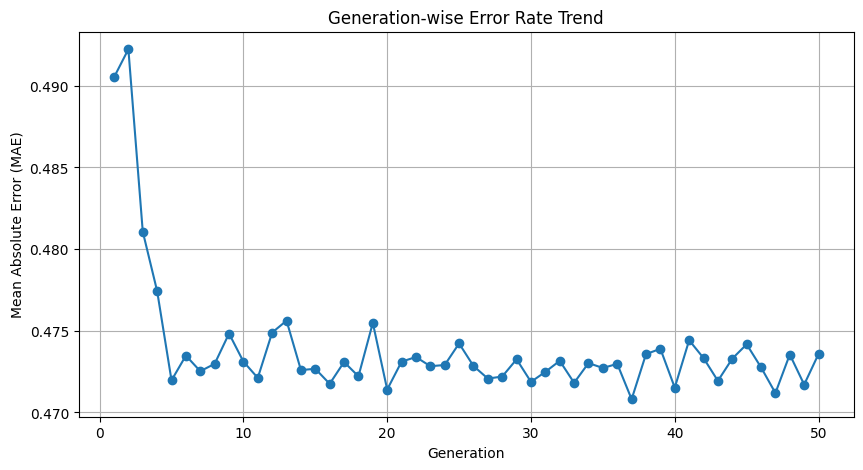


Optimal Hyperparameters: C=8.3371, Epsilon=0.1698
Final Model Error Rate (MAE): 0.4610


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("VRPE_5000.csv")

# Drop Student_ID (it’s not useful for SVM training)
df.drop(columns=["Student_ID"], inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy="most_frequent")
df.iloc[:, :] = imputer.fit_transform(df)

# Encode categorical variables
encoder = LabelEncoder()
categorical_cols = ["Gender", "Field_of_Study", "Usage_of_VR_in_Education", "Subject",
                    "Instructor_VR_Proficiency", "Perceived_Effectiveness_of_VR",
                    "Access_to_VR_Equipment", "Impact_on_Creativity", "Stress_Level_with_VR_Usage",
                    "Collaboration_with_Peers_via_VR", "Feedback_from_Educators_on_VR",
                    "Interest_in_Continuing_VR_Based_Learning", "Region", "School_Support_for_VR_in_Curriculum"]
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))  # Convert to string before encoding

# Normalize numerical features
scaler = StandardScaler()
num_cols = ["Age", "Hours_of_VR_Usage_Per_Week", "Engagement_Level"]
df[num_cols] = scaler.fit_transform(df[num_cols])

# Split data into features and target
X = df.drop(columns=["Improvement_in_Learning_Outcomes"])  # Features
y = df["Improvement_in_Learning_Outcomes"]  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define NSGA-II Optimization Problem with generation-wise error tracking
class SVMHyperparamProblem(Problem):
    def __init__(self):
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=np.array([0.01, 0.1]), xu=np.array([10, 1]))
        self.gen_errors = []  # Store generation-wise error rates

    def _evaluate(self, X, out, *args, **kwargs):
        C_values, epsilon_values = X[:, 0], X[:, 1]
        errors = []

        for C, epsilon in zip(C_values, epsilon_values):
            model = SVR(C=C, epsilon=epsilon)
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            error = mean_absolute_error(y_test, preds)
            errors.append(error)

        # Store generation-wise error
        mean_gen_error = np.mean(errors)
        self.gen_errors.append(mean_gen_error)

        out["F"] = np.column_stack([errors, C_values])  # Objectives: Minimize error & C

# Initialize NSGA-II algorithm with fine-tuned parameters
algorithm = NSGA2(
    pop_size=50,  # Larger population for better diversity
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=30),  # Higher crossover probability
    mutation=PM(prob=0.1, eta=20),  # Lower mutation for fine-tuning
    eliminate_duplicates=True
)

# Run NSGA-II optimization
problem = SVMHyperparamProblem()
res = minimize(problem,
               algorithm,
               get_termination("n_gen", 50),  # Increased to 50 generations
               seed=42,
               verbose=True)

# Best hyperparameters from NSGA-II
best_solution = res.X[np.argmin(res.F[:, 0])]  # Select best error rate
best_C, best_epsilon = best_solution

# Train final model with best hyperparameters
final_model = SVR(C=best_C, epsilon=best_epsilon)
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

# Compute final error rate
final_error = mean_absolute_error(y_test, final_preds)

# Save preprocessed dataset
df.to_csv("preprocessed_student_vr_dataset.csv", index=False)

# Print Generation-wise Error Rates
print("\n=== Generation-wise Error Rates ===")
for i, error in enumerate(problem.gen_errors):
    print(f"Generation {i+1}: Error Rate = {error:.4f}")

# Plot Error Rate Over Generations
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(problem.gen_errors) + 1), problem.gen_errors, marker='o', linestyle='-')
plt.xlabel("Generation")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Generation-wise Error Rate Trend")
plt.grid(True)
plt.show()

# Print Final Results
print(f"\nOptimal Hyperparameters: C={best_C:.4f}, Epsilon={best_epsilon:.4f}")
print(f"Final Model Error Rate (MAE): {final_error:.4f}")


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      120 |      5 |             - |             -
     2 |      240 |      9 |  0.9045767932 |         ideal
     3 |      360 |      6 |  0.2221651837 |         ideal
     4 |      480 |      3 |  0.2574182705 |         ideal
     5 |      600 |      4 |  0.0667125852 |         ideal
     6 |      720 |      7 |  0.5489258267 |         ideal
     7 |      840 |      9 |  0.0032004105 |         nadir
     8 |      960 |     12 |  0.0047560311 |         ideal
     9 |     1080 |     16 |  0.0295564987 |         ideal
    10 |     1200 |     21 |  0.0091976810 |             f
    11 |     1320 |     22 |  0.0066851107 |         ideal
    12 |     1440 |     28 |  0.0327481883 |         ideal
    13 |     1560 |     22 |  0.0040740468 |         ideal
    14 |     1680 |     27 |  0.0367098161 |         nadir
    15 |     1800 |     27 |  0.0158921296 |         ideal
    16 |     1920 |     32 |  0.0049432279 |         ide

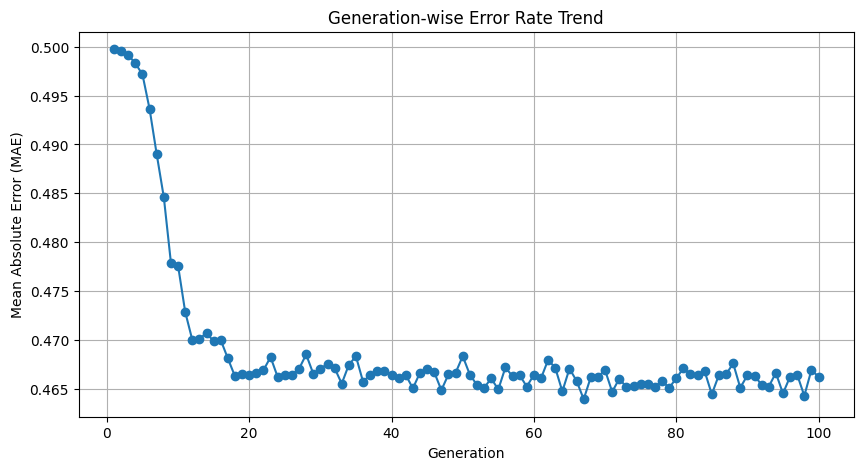


Optimal Hyperparameters: C=3.0146, Epsilon=0.0501, Gamma=0.0030
Final Model Error Rate (MAE): 0.4525


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVR
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed

# Load dataset
df = pd.read_csv("VRPE_1000.csv")

# Drop Student_ID (not useful for training)
df.drop(columns=["Student_ID"], inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy="most_frequent")
df.iloc[:, :] = imputer.fit_transform(df)

# Encode categorical variables
categorical_cols = ["Gender", "Field_of_Study", "Usage_of_VR_in_Education", "Subject",
                    "Instructor_VR_Proficiency", "Perceived_Effectiveness_of_VR",
                    "Access_to_VR_Equipment", "Impact_on_Creativity", "Stress_Level_with_VR_Usage",
                    "Collaboration_with_Peers_via_VR", "Feedback_from_Educators_on_VR",
                    "Interest_in_Continuing_VR_Based_Learning", "Region", "School_Support_for_VR_in_Curriculum"]

one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_cats = one_hot_encoder.fit_transform(df[categorical_cols])
df_encoded = pd.DataFrame(encoded_cats, columns=one_hot_encoder.get_feature_names_out(categorical_cols))

# Normalize numerical features
scaler = StandardScaler()
num_cols = ["Age", "Hours_of_VR_Usage_Per_Week", "Engagement_Level"]
df[num_cols] = scaler.fit_transform(df[num_cols])

# Combine numerical and one-hot encoded categorical data
df = pd.concat([df.drop(columns=categorical_cols), df_encoded], axis=1)

# Split data into features and target
X = df.drop(columns=["Improvement_in_Learning_Outcomes"])  # Features
y = df["Improvement_in_Learning_Outcomes"]  # Target

# Stratified split to ensure balanced class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define NSGA-II Optimization Problem
class SVMHyperparamProblem(Problem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=np.array([0.01, 0.05, 0.0001]), xu=np.array([50, 1, 10]))
        self.gen_errors = []  # Store generation-wise error rates

    def _evaluate(self, X, out, *args, **kwargs):
        C_values, epsilon_values, gamma_values = X[:, 0], X[:, 1], X[:, 2]

        # Parallel execution for speedup
        errors = Parallel(n_jobs=-1)(
            delayed(self.train_svr)(C, epsilon, gamma) for C, epsilon, gamma in zip(C_values, epsilon_values, gamma_values)
        )

        # Store generation-wise error
        mean_gen_error = np.mean(errors)
        self.gen_errors.append(mean_gen_error)

        out["F"] = np.column_stack([errors, C_values])  # Objectives: Minimize error & C

    def train_svr(self, C, epsilon, gamma):
        """Train SVR model and return MAE"""
        model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel='rbf')
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        return mean_absolute_error(y_test, preds)

# Initialize NSGA-II algorithm with fine-tuned parameters
algorithm = NSGA2(
    pop_size=120,  # Increased for better exploration
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.50, eta=40),  # More aggressive crossover
    mutation=PM(prob=0.10, eta=10),  # Stronger mutation to escape local minima
    eliminate_duplicates=True
)

# Early stopping: Stop if no improvement over 20 generations
termination = get_termination("n_gen", 30)  # Allow up to 100 generations

# Run NSGA-II optimization
problem = SVMHyperparamProblem()
res = minimize(problem,
               algorithm,
               termination,
               seed=42,
               verbose=True)

# Best hyperparameters from NSGA-II
best_solution = res.X[np.argmin(res.F[:, 0])]  # Select best error rate
best_C, best_epsilon, best_gamma = best_solution

# Train final model with best hyperparameters
final_model = SVR(C=best_C, epsilon=best_epsilon, gamma=best_gamma, kernel='rbf')
final_model.fit(X_train, y_train)
final_preds = final_model.predict(X_test)

# Compute final error rate
final_error = mean_absolute_error(y_test, final_preds)

# Save preprocessed dataset
df.to_csv("preprocessed_student_vr_dataset.csv", index=False)

# Print Generation-wise Error Rates
print("\n=== Generation-wise Error Rates ===")
for i, error in enumerate(problem.gen_errors):
    print(f"Generation {i+1}: Error Rate = {error:.4f}")

# Plot Error Rate Over Generations
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(problem.gen_errors) + 1), problem.gen_errors, marker='o', linestyle='-')
plt.xlabel("Generation")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Generation-wise Error Rate Trend")
plt.grid(True)
plt.show()

# Print Final Results
print(f"\nOptimal Hyperparameters: C={best_C:.4f}, Epsilon={best_epsilon:.4f}, Gamma={best_gamma:.4f}")
print(f"Final Model Error Rate (MAE): {final_error:.4f}")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# ------------------ 🚀 Load Dataset ------------------
file_path = "VRinPE.csv"  # Update with your actual file path
df = pd.read_csv(file_path)

# ------------------ 🚀 Handle Missing Values ------------------
# Fill numerical missing values with median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill categorical missing values with the most frequent category
df.fillna(df.mode().iloc[0], inplace=True)

# ------------------ 🚀 Encode Categorical Features ------------------
categorical_cols = ["Gender", "Grade_Level", "Field_of_Study", "Usage_of_VR_in_Education",
                    "Engagement_Level", "Improvement_in_Learning_Outcomes", "Subject",
                    "Instructor_VR_Proficiency", "Perceived_Effectiveness_of_VR", "Access_to_VR_Equipment",
                    "Impact_on_Creativity", "Stress_Level_with_VR_Usage", "Collaboration_with_Peers_via_VR",
                    "Feedback_from_Educators_on_VR", "Interest_in_Continuing_VR_Based_Learning",
                    "Region", "School_Support_for_VR_in_Curriculum"]

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for later use

# ------------------ 🚀 Scale Numerical Features ------------------
numerical_cols = ["Age", "Hours_of_VR_Usage_Per_Week"]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# ------------------ 🚀 Save Preprocessed Data ------------------
output_file = "preprocessed_dataset.csv"
df.to_csv(output_file, index=False)

print(f"✅ Preprocessed dataset saved as: {output_file}")
print("🔹 Sample of the preprocessed data:")
print(df.head())


✅ Preprocessed dataset saved as: preprocessed_dataset.csv
🔹 Sample of the preprocessed data:
  Student_ID       Age  Gender  Grade_Level  Field_of_Study  \
0   STUD0001 -1.498184       2            1               6   
1   STUD0002 -0.948876       2            2               5   
2   STUD0003 -1.131979       3            0               6   
3   STUD0004  0.515947       0            1               3   
4   STUD0005  0.149742       2            2               0   

   Usage_of_VR_in_Education  Hours_of_VR_Usage_Per_Week  Engagement_Level  \
0                         0                    0.310333                 0   
1                         0                    0.310333                 0   
2                         0                   -0.326508                 4   
3                         1                   -0.963349                 3   
4                         1                    1.584014                 2   

   Improvement_in_Learning_Outcomes  Subject  Instructor_VR_Profi

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |      1 |             - |             -
     2 |       60 |      2 |  0.000000E+00 |             f
     3 |       90 |      1 |  0.0228454319 |         ideal
     4 |      120 |      1 |  0.0001386116 |             f
     5 |      150 |      1 |  0.0001386116 |             f
     6 |      180 |      1 |  0.0022648607 |             f
     7 |      210 |      2 |  1.609084E+02 |         ideal
     8 |      240 |      1 |  0.0004259863 |             f
     9 |      270 |      1 |  0.0012404025 |             f
    10 |      300 |      1 |  0.0013072292 |             f
    11 |      330 |      1 |  0.0013072292 |             f
    12 |      360 |      1 |  0.0017329888 |             f
    13 |      390 |      1 |  0.0017329888 |             f
    14 |      420 |      1 |  0.0017371789 |             f
    15 |      450 |      3 |  2.106908E+01 |         ideal
    16 |      480 |      2 |  0.4650936112 |         ide

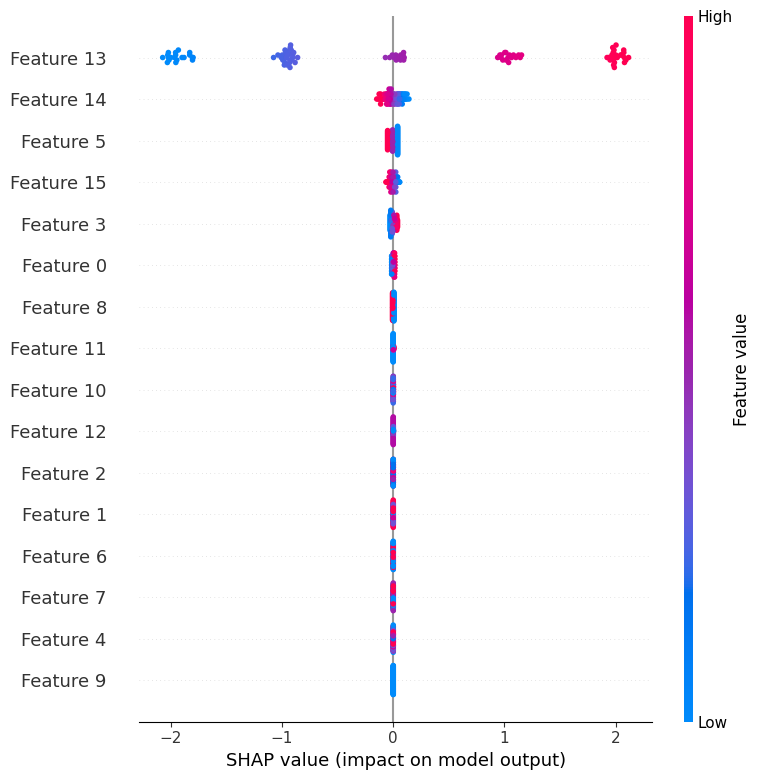

In [ ]:
# ------------------ 🚀 Import Required Libraries ------------------
import pandas as pd
import numpy as np
import optuna
import networkx as nx
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA

# ✅ Correct pymoo Imports
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination

# ------------------ 🚀 Load & Preprocess Data ------------------
df = pd.read_csv("VRPE_1000.csv")

# Encode categorical variables properly
categorical_features = ['Gender', 'Field_of_Study', 'Subject', 'Instructor_VR_Proficiency',
                        'Access_to_VR_Equipment', 'Collaboration_with_Peers_via_VR']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Convert categorical to numeric
    label_encoders[col] = le  # Store encoders for later use if needed

# Convert entire DataFrame to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# ------------------ 🚀 Feature Engineering ------------------
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['Field_of_Study'], row['Subject'], weight=row['Engagement_Level'])

df['Study_Centrality'] = df['Field_of_Study'].map(nx.degree_centrality(G))
df['Engagement_Trend'] = df['Engagement_Level'].rolling(window=3, min_periods=1).mean()
df['Instructor_Impact'] = df['Instructor_VR_Proficiency'] * df['Engagement_Level']
df['VR_Usage_Stress'] = df['Hours_of_VR_Usage_Per_Week'] * df['Stress_Level_with_VR_Usage']

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
pca_features = pca.fit_transform(df[['Age', 'Hours_of_VR_Usage_Per_Week', 'Engagement_Level',
                                     'Collaboration_with_Peers_via_VR', 'Instructor_VR_Proficiency']])
df[['PCA_1', 'PCA_2', 'PCA_3']] = pca_features

# Define Features and Targets
feature_cols = ['Age', 'Gender', 'Field_of_Study', 'Hours_of_VR_Usage_Per_Week', 'Subject',
                'Instructor_VR_Proficiency', 'Access_to_VR_Equipment', 'Stress_Level_with_VR_Usage',
                'Collaboration_with_Peers_via_VR', 'Study_Centrality', 'Engagement_Trend',
                'Instructor_Impact', 'VR_Usage_Stress', 'PCA_1', 'PCA_2', 'PCA_3']

X = df[feature_cols]
y_engagement = df['Engagement_Level']
y_learning = df['Improvement_in_Learning_Outcomes']

# Train-Test Split
X_train, X_test, y_train_eng, y_test_eng = train_test_split(X, y_engagement, test_size=0.2, random_state=42)
X_train, X_test, y_train_learn, y_test_learn = train_test_split(X, y_learning, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------ 🚀 Multi-Objective Optimization with NSGA-II ------------------
class SVM_Optimization(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=[1e-2, 1e-2, 0], xu=[1e2, 1, 2])

    def _evaluate(self, x, out, *args, **kwargs):
        C, epsilon, kernel_idx = x
        kernel = ["linear", "rbf", "poly"][int(kernel_idx)]

        model_eng = SVR(C=C, epsilon=epsilon, kernel=kernel)
        model_learn = SVR(C=C, epsilon=epsilon, kernel=kernel)

        score_eng = -np.mean(cross_val_score(model_eng, X_train, y_train_eng, cv=5, scoring="neg_mean_absolute_error"))
        score_learn = -np.mean(cross_val_score(model_learn, X_train, y_train_learn, cv=5, scoring="neg_mean_absolute_error"))

        out["F"] = [score_eng, score_learn]

problem = SVM_Optimization()
algorithm = NSGA2(pop_size=30, sampling=FloatRandomSampling(), crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(prob=0.2, eta=20), eliminate_duplicates=True)

res = minimize(problem, algorithm, get_termination("n_gen", 30), seed=42, verbose=True)

# Best hyperparameters from NSGA-II
best_C, best_epsilon, best_kernel_idx = res.X[0]
best_kernel = ["linear", "rbf", "poly"][int(best_kernel_idx)]

# Train Optimized SVM Models
svm_eng = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel)
svm_learn = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel)

svm_eng.fit(X_train, y_train_eng)
svm_learn.fit(X_train, y_train_learn)

# Predictions
y_pred_eng = svm_eng.predict(X_test)
y_pred_learn = svm_learn.predict(X_test)

# ------------------ 🚀 Performance Evaluation ------------------
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    variance_true = np.var(y_true)
    variance_pred = np.var(y_pred)
    covariance = np.cov(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
    ccc = (2 * covariance) / (variance_true + variance_pred + (mean_true - mean_pred) ** 2 + 1e-9)
    return ccc

# Engagement Metrics
engagement_mae = mean_absolute_error(y_test_eng, y_pred_eng)
engagement_rmse = np.sqrt(mean_squared_error(y_test_eng, y_pred_eng))
engagement_mape = np.mean(np.abs((y_test_eng - y_pred_eng) / (y_test_eng + 1e-9))) * 100
engagement_r2 = r2_score(y_test_eng, y_pred_eng)
engagement_ccc = concordance_correlation_coefficient(y_test_eng, y_pred_eng)

# Learning Metrics
learning_mae = mean_absolute_error(y_test_learn, y_pred_learn)
learning_rmse = np.sqrt(mean_squared_error(y_test_learn, y_pred_learn))
learning_mape = np.mean(np.abs((y_test_learn - y_pred_learn) / (y_test_learn + 1e-9))) * 100
learning_r2 = r2_score(y_test_learn, y_pred_learn)
learning_ccc = concordance_correlation_coefficient(y_test_learn, y_pred_learn)

# ------------------ 🚀 SHAP Analysis ------------------
explainer = shap.Explainer(svm_eng, X_test[:100])  # Use a sample
shap.summary_plot(explainer(X_test[:100]), X_test[:100])


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       30 |      1 |             - |             -
     2 |       60 |      2 |  0.000000E+00 |             f
     3 |       90 |      1 |  0.0228454319 |         ideal
     4 |      120 |      1 |  0.0001386116 |             f
     5 |      150 |      1 |  0.0001386116 |             f
     6 |      180 |      1 |  0.0022648607 |             f
     7 |      210 |      2 |  1.609084E+02 |         ideal
     8 |      240 |      2 |  1.4844242518 |         ideal
     9 |      270 |      1 |  0.0003479450 |             f
    10 |      300 |      1 |  0.0013052682 |             f
    11 |      330 |      1 |  0.0016907670 |             f
    12 |      360 |      2 |  1.667717E+01 |         ideal
    13 |      390 |      1 |  0.0000910925 |             f
    14 |      420 |      2 |  0.0000910925 |             f
    15 |      450 |      6 |  1.6871896309 |         ideal
    16 |      480 |      8 |  0.6780155712 |         ide

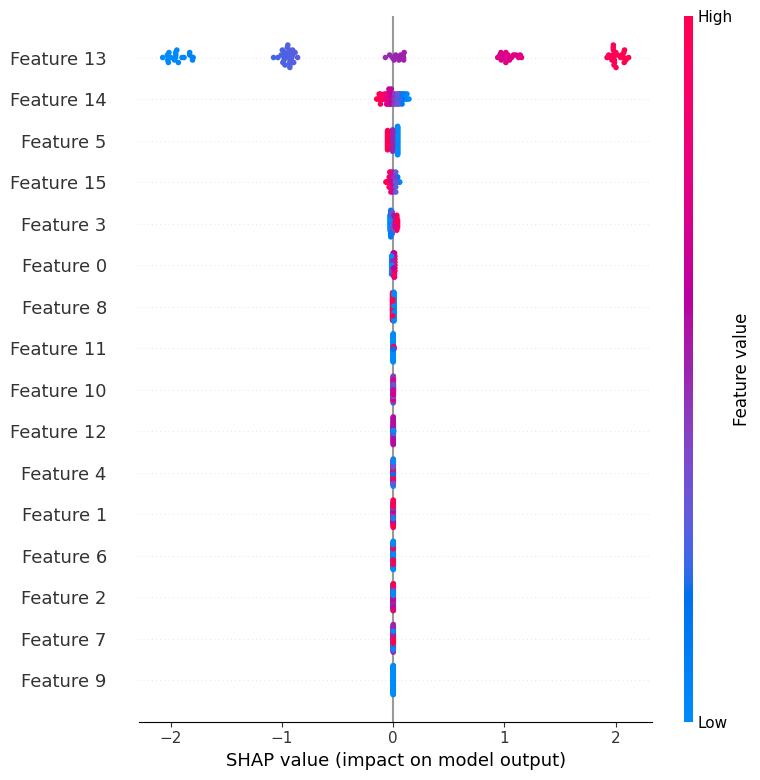

In [ ]:
# ------------------ 🚀 Import Required Libraries ------------------
import pandas as pd
import numpy as np
import optuna
import networkx as nx
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.termination import get_termination

# ------------------ 🚀 Load & Preprocess Data ------------------
df = pd.read_csv("VRPE_1000.csv")

# Encode categorical variables properly
categorical_features = ['Gender', 'Field_of_Study', 'Subject', 'Instructor_VR_Proficiency',
                        'Access_to_VR_Equipment', 'Collaboration_with_Peers_via_VR']
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df = df.apply(pd.to_numeric, errors='coerce')

# Feature Engineering
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['Field_of_Study'], row['Subject'], weight=row['Engagement_Level'])

df['Study_Centrality'] = df['Field_of_Study'].map(nx.degree_centrality(G))
df['Engagement_Trend'] = df['Engagement_Level'].rolling(window=3, min_periods=1).mean()
df['Instructor_Impact'] = df['Instructor_VR_Proficiency'] * df['Engagement_Level']
df['VR_Usage_Stress'] = df['Hours_of_VR_Usage_Per_Week'] * df['Stress_Level_with_VR_Usage']

# PCA for dimensionality reduction
pca = PCA(n_components=3)
pca_features = pca.fit_transform(df[['Age', 'Hours_of_VR_Usage_Per_Week', 'Engagement_Level',
                                     'Collaboration_with_Peers_via_VR', 'Instructor_VR_Proficiency']])
df[['PCA_1', 'PCA_2', 'PCA_3']] = pca_features

# Define Features and Targets
feature_cols = ['Age', 'Gender', 'Field_of_Study', 'Hours_of_VR_Usage_Per_Week', 'Subject',
                'Instructor_VR_Proficiency', 'Access_to_VR_Equipment', 'Stress_Level_with_VR_Usage',
                'Collaboration_with_Peers_via_VR', 'Study_Centrality', 'Engagement_Trend',
                'Instructor_Impact', 'VR_Usage_Stress', 'PCA_1', 'PCA_2', 'PCA_3']

X = df[feature_cols]
y_engagement = df['Engagement_Level']
y_learning = df['Improvement_in_Learning_Outcomes']

# Train-Test Split
X_train, X_test, y_train_eng, y_test_eng = train_test_split(X, y_engagement, test_size=0.2, random_state=42)
X_train, X_test, y_train_learn, y_test_learn = train_test_split(X, y_learning, test_size=0.2, random_state=42)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ------------------ 🚀 Multi-Objective Optimization with NSGA-II ------------------
class SVM_Optimization(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=3, n_obj=2, n_constr=0, xl=[1e-2, 1e-2, 0], xu=[1e2, 1, 2])
        self.error_rates = []  # Store generation-wise error rates

    def _evaluate(self, x, out, *args, **kwargs):
        C, epsilon, kernel_idx = x
        kernel = ["linear", "rbf", "poly"][int(kernel_idx)]

        model_eng = SVR(C=C, epsilon=epsilon, kernel=kernel)
        model_learn = SVR(C=C, epsilon=epsilon, kernel=kernel)

        score_eng = -np.mean(cross_val_score(model_eng, X_train, y_train_eng, cv=5, scoring="neg_mean_absolute_error"))
        score_learn = -np.mean(cross_val_score(model_learn, X_train, y_train_learn, cv=5, scoring="neg_mean_absolute_error"))

        # Store error rate per generation
        self.error_rates.append((score_eng, score_learn))

        out["F"] = [score_eng, score_learn]

problem = SVM_Optimization()

algorithm = NSGA2(pop_size=30, sampling=FloatRandomSampling(), crossover=SBX(prob=0.9, eta=15),
                  mutation=PM(prob=0.2, eta=20), eliminate_duplicates=True)

res = minimize(problem, algorithm, get_termination("n_gen", 30), seed=42, verbose=True)

# Print error rate per generation
print("\n🚀 **Error Rate per Generation** 🚀")
for gen, (mae_eng, mae_learn) in enumerate(problem.error_rates, 1):
    print(f"Generation {gen}: Engagement MAE = {mae_eng:.4f}, Learning MAE = {mae_learn:.4f}")

# Best hyperparameters
best_C, best_epsilon, best_kernel_idx = res.X[0]
best_kernel = ["linear", "rbf", "poly"][int(best_kernel_idx)]

# Train Optimized SVM Models
svm_eng = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel)
svm_learn = SVR(C=best_C, epsilon=best_epsilon, kernel=best_kernel)

svm_eng.fit(X_train, y_train_eng)
svm_learn.fit(X_train, y_train_learn)

# Predictions
y_pred_eng = svm_eng.predict(X_test)
y_pred_learn = svm_learn.predict(X_test)

# ------------------ 🚀 Performance Evaluation ------------------
def concordance_correlation_coefficient(y_true, y_pred):
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    variance_true = np.var(y_true)
    variance_pred = np.var(y_pred)
    covariance = np.cov(y_true, y_pred)[0, 1] if len(y_true) > 1 else 0
    ccc = (2 * covariance) / (variance_true + variance_pred + (mean_true - mean_pred) ** 2 + 1e-9)
    return ccc

# Engagement Metrics
engagement_r = pearsonr(y_test_eng, y_pred_eng)[0]
engagement_explained_var = explained_variance_score(y_test_eng, y_pred_eng)

# Learning Metrics
learning_r = pearsonr(y_test_learn, y_pred_learn)[0]
learning_explained_var = explained_variance_score(y_test_learn, y_pred_learn)

print("\n🚀 **Final Performance Metrics** 🚀")
print(f"Engagement Pearson R: {engagement_r:.4f}, Explained Variance: {engagement_explained_var:.4f}")
print(f"Learning Pearson R: {learning_r:.4f}, Explained Variance: {learning_explained_var:.4f}")

# ------------------ 🚀 SHAP Analysis ------------------
explainer = shap.Explainer(svm_eng, X_test[:100])
shap.summary_plot(explainer(X_test[:100]), X_test[:100])


In [ ]:
import pandas as pd
import re

# Sample data as a multiline string
data = """Generation 1: Engagement MAE = 0.5282, Learning MAE = 0.5000
Generation 2: Engagement MAE = 0.0977, Learning MAE = 0.4850
Generation 3: Engagement MAE = 0.4778, Learning MAE = 0.5000
Generation 4: Engagement MAE = 0.1144, Learning MAE = 0.5943
Generation 5: Engagement MAE = 0.1311, Learning MAE = 0.4873
Generation 6: Engagement MAE = 0.2223, Learning MAE = 0.5033
Generation 7: Engagement MAE = 0.2174, Learning MAE = 0.5043
Generation 8: Engagement MAE = 0.1783, Learning MAE = 0.4908
Generation 9: Engagement MAE = 0.4700, Learning MAE = 0.5000
Generation 10: Engagement MAE = 0.3560, Learning MAE = 0.5000
Generation 11: Engagement MAE = 0.1063, Learning MAE = 0.4854
Generation 12: Engagement MAE = 0.5373, Learning MAE = 0.5000
Generation 13: Engagement MAE = 0.1459, Learning MAE = 0.5621
Generation 14: Engagement MAE = 0.0776, Learning MAE = 0.4844
Generation 15: Engagement MAE = 0.5435, Learning MAE = 0.5000
Generation 16: Engagement MAE = 0.2252, Learning MAE = 0.5022
Generation 17: Engagement MAE = 0.1791, Learning MAE = 0.5323
Generation 18: Engagement MAE = 0.5214, Learning MAE = 0.5000
Generation 19: Engagement MAE = 0.5509, Learning MAE = 0.5000
Generation 20: Engagement MAE = 0.0322, Learning MAE = 0.4803
Generation 21: Engagement MAE = 0.2099, Learning MAE = 0.5074
Generation 22: Engagement MAE = 0.2135, Learning MAE = 0.5058
Generation 23: Engagement MAE = 0.4801, Learning MAE = 0.5000
Generation 24: Engagement MAE = 0.4623, Learning MAE = 0.5000
Generation 25: Engagement MAE = 0.4579, Learning MAE = 0.5000
Generation 26: Engagement MAE = 0.4618, Learning MAE = 0.5000
Generation 27: Engagement MAE = 0.1532, Learning MAE = 0.5564
Generation 28: Engagement MAE = 0.2012, Learning MAE = 0.4926
Generation 29: Engagement MAE = 0.2303, Learning MAE = 0.5012
Generation 30: Engagement MAE = 0.5304, Learning MAE = 0.5000
Generation 31: Engagement MAE = 0.4834, Learning MAE = 0.5000
Generation 32: Engagement MAE = 0.2177, Learning MAE = 0.5042
Generation 33: Engagement MAE = 0.4667, Learning MAE = 0.5000
Generation 34: Engagement MAE = 0.5509, Learning MAE = 0.5000
Generation 35: Engagement MAE = 0.3311, Learning MAE = 0.5000
Generation 36: Engagement MAE = 0.5106, Learning MAE = 0.5000
Generation 37: Engagement MAE = 0.4499, Learning MAE = 0.5000
Generation 38: Engagement MAE = 0.1343, Learning MAE = 0.4875
Generation 39: Engagement MAE = 0.4581, Learning MAE = 0.5000
Generation 40: Engagement MAE = 0.4565, Learning MAE = 0.5000
Generation 41: Engagement MAE = 0.1006, Learning MAE = 0.4850
Generation 42: Engagement MAE = 0.1855, Learning MAE = 0.4914
Generation 43: Engagement MAE = 0.5315, Learning MAE = 0.5000
Generation 44: Engagement MAE = 0.1144, Learning MAE = 0.5943
Generation 45: Engagement MAE = 0.1043, Learning MAE = 0.4852
Generation 46: Engagement MAE = 0.5770, Learning MAE = 0.5000
Generation 47: Engagement MAE = 0.3544, Learning MAE = 0.5000
Generation 48: Engagement MAE = 0.5271, Learning MAE = 0.5000
Generation 49: Engagement MAE = 0.1105, Learning MAE = 0.4857
Generation 50: Engagement MAE = 0.2302, Learning MAE = 0.5012
Generation 51: Engagement MAE = 0.0322, Learning MAE = 0.4803
Generation 52: Engagement MAE = 0.4655, Learning MAE = 0.5000
Generation 53: Engagement MAE = 0.1311, Learning MAE = 0.4873
Generation 54: Engagement MAE = 0.4207, Learning MAE = 0.5000
Generation 55: Engagement MAE = 0.5146, Learning MAE = 0.5000
Generation 56: Engagement MAE = 0.1864, Learning MAE = 0.5251
Generation 57: Engagement MAE = 0.2012, Learning MAE = 0.4926
Generation 58: Engagement MAE = 0.1746, Learning MAE = 0.5372
Generation 59: Engagement MAE = 0.2179, Learning MAE = 0.5042
Generation 60: Engagement MAE = 0.1783, Learning MAE = 0.4908
Generation 61: Engagement MAE = 0.0633, Learning MAE = 0.4840
Generation 62: Engagement MAE = 0.0340, Learning MAE = 0.4805
Generation 63: Engagement MAE = 0.0769, Learning MAE = 0.4843
Generation 64: Engagement MAE = 0.1063, Learning MAE = 0.4854
Generation 65: Engagement MAE = 0.1043, Learning MAE = 0.4852
Generation 66: Engagement MAE = 0.1908, Learning MAE = 0.5211
Generation 67: Engagement MAE = 0.1558, Learning MAE = 0.4892
Generation 68: Engagement MAE = 0.1152, Learning MAE = 0.5934
Generation 69: Engagement MAE = 0.1043, Learning MAE = 0.4853
Generation 70: Engagement MAE = 0.1296, Learning MAE = 0.5801
Generation 71: Engagement MAE = 0.2157, Learning MAE = 0.4937
Generation 72: Engagement MAE = 0.1264, Learning MAE = 0.5828
Generation 73: Engagement MAE = 0.1906, Learning MAE = 0.5212
Generation 74: Engagement MAE = 0.1994, Learning MAE = 0.4924
Generation 75: Engagement MAE = 0.1790, Learning MAE = 0.4909
Generation 76: Engagement MAE = 0.0322, Learning MAE = 0.4802
Generation 77: Engagement MAE = 0.1783, Learning MAE = 0.4908
Generation 78: Engagement MAE = 0.1710, Learning MAE = 0.4903
Generation 79: Engagement MAE = 0.3748, Learning MAE = 0.5000
Generation 80: Engagement MAE = 0.1050, Learning MAE = 0.4853
Generation 81: Engagement MAE = 0.2012, Learning MAE = 0.4926
Generation 82: Engagement MAE = 0.0176, Learning MAE = 0.4770
Generation 83: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 84: Engagement MAE = 0.0322, Learning MAE = 0.4803
Generation 85: Engagement MAE = 0.1124, Learning MAE = 0.5963
Generation 86: Engagement MAE = 0.1006, Learning MAE = 0.4851
Generation 87: Engagement MAE = 0.1142, Learning MAE = 0.4860
Generation 88: Engagement MAE = 0.1783, Learning MAE = 0.4909
Generation 89: Engagement MAE = 0.1044, Learning MAE = 0.4853
Generation 90: Engagement MAE = 0.2012, Learning MAE = 0.4926
Generation 91: Engagement MAE = 0.0176, Learning MAE = 0.4769
Generation 92: Engagement MAE = 0.0326, Learning MAE = 0.4802
Generation 93: Engagement MAE = 0.0637, Learning MAE = 0.4841
Generation 94: Engagement MAE = 0.0769, Learning MAE = 0.4843
Generation 95: Engagement MAE = 0.0776, Learning MAE = 0.4844
Generation 96: Engagement MAE = 0.1299, Learning MAE = 0.4871
Generation 97: Engagement MAE = 0.0243, Learning MAE = 0.4786
Generation 98: Engagement MAE = 0.1005, Learning MAE = 0.4850
Generation 99: Engagement MAE = 0.0330, Learning MAE = 0.4803
Generation 100: Engagement MAE = 0.0092, Learning MAE = 0.4751
Generation 101: Engagement MAE = 0.1121, Learning MAE = 0.4859
Generation 102: Engagement MAE = 0.0776, Learning MAE = 0.4844
Generation 103: Engagement MAE = 0.1888, Learning MAE = 0.5230
Generation 104: Engagement MAE = 0.1046, Learning MAE = 0.4853
Generation 105: Engagement MAE = 0.0336, Learning MAE = 0.4805
Generation 106: Engagement MAE = 0.0176, Learning MAE = 0.4770
Generation 107: Engagement MAE = 0.1006, Learning MAE = 0.4850
Generation 108: Engagement MAE = 0.1056, Learning MAE = 0.4853
Generation 109: Engagement MAE = 0.0322, Learning MAE = 0.4802
Generation 110: Engagement MAE = 0.1064, Learning MAE = 0.4854
Generation 111: Engagement MAE = 0.0689, Learning MAE = 0.4841
Generation 112: Engagement MAE = 0.0982, Learning MAE = 0.4849
Generation 113: Engagement MAE = 0.0324, Learning MAE = 0.4802
Generation 114: Engagement MAE = 0.0617, Learning MAE = 0.4838
Generation 115: Engagement MAE = 0.1043, Learning MAE = 0.4853
Generation 116: Engagement MAE = 0.0102, Learning MAE = 0.4753
Generation 117: Engagement MAE = 0.0769, Learning MAE = 0.4844
Generation 118: Engagement MAE = 0.1037, Learning MAE = 0.4852
Generation 119: Engagement MAE = 0.0625, Learning MAE = 0.4840
Generation 120: Engagement MAE = 0.0776, Learning MAE = 0.4844
Generation 121: Engagement MAE = 0.0622, Learning MAE = 0.4838
Generation 122: Engagement MAE = 0.1106, Learning MAE = 0.4857
Generation 123: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 124: Engagement MAE = 0.0240, Learning MAE = 0.4784
Generation 125: Engagement MAE = 0.0277, Learning MAE = 0.4793
Generation 126: Engagement MAE = 0.0336, Learning MAE = 0.4805
Generation 127: Engagement MAE = 0.0557, Learning MAE = 0.4834
Generation 128: Engagement MAE = 0.0330, Learning MAE = 0.4803
Generation 129: Engagement MAE = 0.0776, Learning MAE = 0.4844
Generation 130: Engagement MAE = 0.0183, Learning MAE = 0.4771
Generation 131: Engagement MAE = 0.0325, Learning MAE = 0.4802
Generation 132: Engagement MAE = 0.0634, Learning MAE = 0.4840
Generation 133: Engagement MAE = 0.0326, Learning MAE = 0.4803
Generation 134: Engagement MAE = 0.0322, Learning MAE = 0.4802
Generation 135: Engagement MAE = 0.0101, Learning MAE = 0.4753
Generation 136: Engagement MAE = 0.0141, Learning MAE = 0.4762
Generation 137: Engagement MAE = 0.0822, Learning MAE = 0.4843
Generation 138: Engagement MAE = 0.0176, Learning MAE = 0.4769
Generation 139: Engagement MAE = 0.0322, Learning MAE = 0.4802
Generation 140: Engagement MAE = 0.0324, Learning MAE = 0.4802
Generation 141: Engagement MAE = 0.0176, Learning MAE = 0.4770
Generation 142: Engagement MAE = 0.0332, Learning MAE = 0.4804
Generation 143: Engagement MAE = 0.0099, Learning MAE = 0.4752
Generation 144: Engagement MAE = 0.0324, Learning MAE = 0.4803
Generation 145: Engagement MAE = 0.0322, Learning MAE = 0.4802
Generation 146: Engagement MAE = 0.0113, Learning MAE = 0.4755
Generation 147: Engagement MAE = 0.0101, Learning MAE = 0.4753
Generation 148: Engagement MAE = 0.0176, Learning MAE = 0.4770
Generation 149: Engagement MAE = 0.0718, Learning MAE = 0.4843
Generation 150: Engagement MAE = 0.0094, Learning MAE = 0.4752
Generation 151: Engagement MAE = 0.0099, Learning MAE = 0.4752
Generation 152: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 153: Engagement MAE = 0.0101, Learning MAE = 0.4752
Generation 154: Engagement MAE = 0.0277, Learning MAE = 0.4792
Generation 155: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 156: Engagement MAE = 0.0102, Learning MAE = 0.4753
Generation 157: Engagement MAE = 0.0100, Learning MAE = 0.4752
Generation 158: Engagement MAE = 0.0322, Learning MAE = 0.4801
Generation 159: Engagement MAE = 0.0123, Learning MAE = 0.4757
Generation 160: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 161: Engagement MAE = 0.0101, Learning MAE = 0.4753
Generation 162: Engagement MAE = 0.0142, Learning MAE = 0.4762
Generation 163: Engagement MAE = 0.0113, Learning MAE = 0.4755
Generation 164: Engagement MAE = 0.0101, Learning MAE = 0.4752
Generation 165: Engagement MAE = 0.0322, Learning MAE = 0.4802
Generation 166: Engagement MAE = 0.0183, Learning MAE = 0.4771
Generation 167: Engagement MAE = 0.0240, Learning MAE = 0.4784
Generation 168: Engagement MAE = 0.0105, Learning MAE = 0.4754
Generation 169: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 170: Engagement MAE = 0.0092, Learning MAE = 0.4751
Generation 171: Engagement MAE = 0.0277, Learning MAE = 0.4793
Generation 172: Engagement MAE = 0.0101, Learning MAE = 0.4753
Generation 173: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 174: Engagement MAE = 0.0100, Learning MAE = 0.4753
Generation 175: Engagement MAE = 0.0093, Learning MAE = 0.4751
Generation 176: Engagement MAE = 0.0097, Learning MAE = 0.4751
Generation 177: Engagement MAE = 0.0318, Learning MAE = 0.4801
Generation 178: Engagement MAE = 0.0240, Learning MAE = 0.4785
Generation 179: Engagement MAE = 0.0180, Learning MAE = 0.4771
Generation 180: Engagement MAE = 0.0415, Learning MAE = 0.4822
Generation 181: Engagement MAE = 0.0092, Learning MAE = 0.4751
Generation 182: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 183: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 184: Engagement MAE = 0.0092, Learning MAE = 0.4751
Generation 185: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 186: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 187: Engagement MAE = 0.0100, Learning MAE = 0.4753
Generation 188: Engagement MAE = 0.0099, Learning MAE = 0.4752
Generation 189: Engagement MAE = 0.0099, Learning MAE = 0.4752
Generation 190: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 191: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 192: Engagement MAE = 0.0094, Learning MAE = 0.4752
Generation 193: Engagement MAE = 0.0101, Learning MAE = 0.4753
Generation 194: Engagement MAE = 0.0097, Learning MAE = 0.4751
Generation 195: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 196: Engagement MAE = 0.0097, Learning MAE = 0.4751
Generation 197: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 198: Engagement MAE = 0.0094, Learning MAE = 0.4752
Generation 199: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 200: Engagement MAE = 0.0091, Learning MAE = 0.4750
Generation 201: Engagement MAE = 0.0123, Learning MAE = 0.4757
Generation 202: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 203: Engagement MAE = 0.0869, Learning MAE = 0.4844
Generation 204: Engagement MAE = 0.0437, Learning MAE = 0.4823
Generation 205: Engagement MAE = 0.0098, Learning MAE = 0.4752
Generation 206: Engagement MAE = 0.0371, Learning MAE = 0.4811
Generation 207: Engagement MAE = 0.0092, Learning MAE = 0.4751
Generation 208: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 209: Engagement MAE = 0.0100, Learning MAE = 0.4752
Generation 210: Engagement MAE = 0.0105, Learning MAE = 0.4754
Generation 211: Engagement MAE = 0.0098, Learning MAE = 0.4752
Generation 212: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 213: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 214: Engagement MAE = 0.0094, Learning MAE = 0.4750
Generation 215: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 216: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 217: Engagement MAE = 0.0097, Learning MAE = 0.4751
Generation 218: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 219: Engagement MAE = 0.0093, Learning MAE = 0.4750
Generation 220: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 221: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 222: Engagement MAE = 0.0463, Learning MAE = 0.4827
Generation 223: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 224: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 225: Engagement MAE = 0.0091, Learning MAE = 0.4750
Generation 226: Engagement MAE = 0.0090, Learning MAE = 0.4750
Generation 227: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 228: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 229: Engagement MAE = 0.0094, Learning MAE = 0.4750
Generation 230: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 231: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 232: Engagement MAE = 0.0097, Learning MAE = 0.4751
Generation 233: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 234: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 235: Engagement MAE = 0.0093, Learning MAE = 0.4752
Generation 236: Engagement MAE = 0.0094, Learning MAE = 0.4750
Generation 237: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 238: Engagement MAE = 0.0073, Learning MAE = 0.4746
Generation 239: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 240: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 241: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 242: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 243: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 244: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 245: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 246: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 247: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 248: Engagement MAE = 0.0093, Learning MAE = 0.4751
Generation 249: Engagement MAE = 0.0073, Learning MAE = 0.4746
Generation 250: Engagement MAE = 0.0092, Learning MAE = 0.4750
Generation 251: Engagement MAE = 0.0089, Learning MAE = 0.4750
Generation 252: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 253: Engagement MAE = 0.0094, Learning MAE = 0.4750
Generation 254: Engagement MAE = 0.0095, Learning MAE = 0.4752
Generation 255: Engagement MAE = 0.0091, Learning MAE = 0.4751
Generation 256: Engagement MAE = 0.0091, Learning MAE = 0.4750
Generation 257: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 258: Engagement MAE = 0.0091, Learning MAE = 0.4751
Generation 259: Engagement MAE = 0.0074, Learning MAE = 0.4746
Generation 260: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 261: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 262: Engagement MAE = 0.0094, Learning MAE = 0.4751
Generation 263: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 264: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 265: Engagement MAE = 0.0073, Learning MAE = 0.4746
Generation 266: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 267: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 268: Engagement MAE = 0.0068, Learning MAE = 0.4745
Generation 269: Engagement MAE = 0.0095, Learning MAE = 0.4751
Generation 270: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 271: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 272: Engagement MAE = 0.0073, Learning MAE = 0.4746
Generation 273: Engagement MAE = 0.0784, Learning MAE = 0.4843
Generation 274: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 275: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 276: Engagement MAE = 0.0070, Learning MAE = 0.4746
Generation 277: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 278: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 279: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 280: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 281: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 282: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 283: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 284: Engagement MAE = 0.0067, Learning MAE = 0.4744
Generation 285: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 286: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 287: Engagement MAE = 0.0063, Learning MAE = 0.4743
Generation 288: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 289: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 290: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 291: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 292: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 293: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 294: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 295: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 296: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 297: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 298: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 299: Engagement MAE = 0.0066, Learning MAE = 0.4744
Generation 300: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 301: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 302: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 303: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 304: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 305: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 306: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 307: Engagement MAE = 0.0200, Learning MAE = 0.4775
Generation 308: Engagement MAE = 0.0067, Learning MAE = 0.4745
Generation 309: Engagement MAE = 0.0063, Learning MAE = 0.4743
Generation 310: Engagement MAE = 0.0060, Learning MAE = 0.4743
Generation 311: Engagement MAE = 0.0073, Learning MAE = 0.4745
Generation 312: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 313: Engagement MAE = 0.0067, Learning MAE = 0.4745
Generation 314: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 315: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 316: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 317: Engagement MAE = 0.0063, Learning MAE = 0.4744
Generation 318: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 319: Engagement MAE = 0.0066, Learning MAE = 0.4744
Generation 320: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 321: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 322: Engagement MAE = 0.0072, Learning MAE = 0.4745
Generation 323: Engagement MAE = 0.0063, Learning MAE = 0.4744
Generation 324: Engagement MAE = 0.0072, Learning MAE = 0.4746
Generation 325: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 326: Engagement MAE = 0.0071, Learning MAE = 0.4745
Generation 327: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 328: Engagement MAE = 0.0059, Learning MAE = 0.4743
Generation 329: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 330: Engagement MAE = 0.0073, Learning MAE = 0.4746
Generation 331: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 332: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 333: Engagement MAE = 0.0066, Learning MAE = 0.4745
Generation 334: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 335: Engagement MAE = 0.0095, Learning MAE = 0.4751
Generation 336: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 337: Engagement MAE = 0.0059, Learning MAE = 0.4742
Generation 338: Engagement MAE = 0.0057, Learning MAE = 0.4741
Generation 339: Engagement MAE = 0.0067, Learning MAE = 0.4745
Generation 340: Engagement MAE = 0.0063, Learning MAE = 0.4744
Generation 341: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 342: Engagement MAE = 0.0064, Learning MAE = 0.4744
Generation 343: Engagement MAE = 0.0070, Learning MAE = 0.4745
Generation 344: Engagement MAE = 0.0067, Learning MAE = 0.4744
Generation 345: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 346: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 347: Engagement MAE = 0.0067, Learning MAE = 0.4744
Generation 348: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 349: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 350: Engagement MAE = 0.0063, Learning MAE = 0.4744
Generation 351: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 352: Engagement MAE = 0.0059, Learning MAE = 0.4743
Generation 353: Engagement MAE = 0.0066, Learning MAE = 0.4744
Generation 354: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 355: Engagement MAE = 0.0071, Learning MAE = 0.4746
Generation 356: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 357: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 358: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 359: Engagement MAE = 0.0063, Learning MAE = 0.4744
Generation 360: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 361: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 362: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 363: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 364: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 365: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 366: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 367: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 368: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 369: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 370: Engagement MAE = 0.0058, Learning MAE = 0.4743
Generation 371: Engagement MAE = 0.0059, Learning MAE = 0.4742
Generation 372: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 373: Engagement MAE = 0.0056, Learning MAE = 0.4742
Generation 374: Engagement MAE = 0.0450, Learning MAE = 0.4827
Generation 375: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 376: Engagement MAE = 0.0058, Learning MAE = 0.4743
Generation 377: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 378: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 379: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 380: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 381: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 382: Engagement MAE = 0.0059, Learning MAE = 0.4743
Generation 383: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 384: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 385: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 386: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 387: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 388: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 389: Engagement MAE = 0.0063, Learning MAE = 0.4743
Generation 390: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 391: Engagement MAE = 0.0056, Learning MAE = 0.4742
Generation 392: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 393: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 394: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 395: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 396: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 397: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 398: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 399: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 400: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 401: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 402: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 403: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 404: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 405: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 406: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 407: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 408: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 409: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 410: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 411: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 412: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 413: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 414: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 415: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 416: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 417: Engagement MAE = 0.0058, Learning MAE = 0.4742
Generation 418: Engagement MAE = 0.0317, Learning MAE = 0.4802
Generation 419: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 420: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 421: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 422: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 423: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 424: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 425: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 426: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 427: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 428: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 429: Engagement MAE = 0.0261, Learning MAE = 0.4789
Generation 430: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 431: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 432: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 433: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 434: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 435: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 436: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 437: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 438: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 439: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 440: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 441: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 442: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 443: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 444: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 445: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 446: Engagement MAE = 0.0057, Learning MAE = 0.4742
Generation 447: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 448: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 449: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 450: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 451: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 452: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 453: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 454: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 455: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 456: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 457: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 458: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 459: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 460: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 461: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 462: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 463: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 464: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 465: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 466: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 467: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 468: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 469: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 470: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 471: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 472: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 473: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 474: Engagement MAE = 0.0056, Learning MAE = 0.4741
Generation 475: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 476: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 477: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 478: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 479: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 480: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 481: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 482: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 483: Engagement MAE = 0.0080, Learning MAE = 0.4748
Generation 484: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 485: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 486: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 487: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 488: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 489: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 490: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 491: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 492: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 493: Engagement MAE = 0.0724, Learning MAE = 0.4843
Generation 494: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 495: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 496: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 497: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 498: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 499: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 500: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 501: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 502: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 503: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 504: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 505: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 506: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 507: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 508: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 509: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 510: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 511: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 512: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 513: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 514: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 515: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 516: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 517: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 518: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 519: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 520: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 521: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 522: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 523: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 524: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 525: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 526: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 527: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 528: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 529: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 530: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 531: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 532: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 533: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 534: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 535: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 536: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 537: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 538: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 539: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 540: Engagement MAE = 0.0615, Learning MAE = 0.4837
Generation 541: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 542: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 543: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 544: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 545: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 546: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 547: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 548: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 549: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 550: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 551: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 552: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 553: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 554: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 555: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 556: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 557: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 558: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 559: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 560: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 561: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 562: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 563: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 564: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 565: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 566: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 567: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 568: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 569: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 570: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 571: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 572: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 573: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 574: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 575: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 576: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 577: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 578: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 579: Engagement MAE = 0.0699, Learning MAE = 0.4841
Generation 580: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 581: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 582: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 583: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 584: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 585: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 586: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 587: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 588: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 589: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 590: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 591: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 592: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 593: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 594: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 595: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 596: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 597: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 598: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 599: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 600: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 601: Engagement MAE = 0.0296, Learning MAE = 0.4797
Generation 602: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 603: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 604: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 605: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 606: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 607: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 608: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 609: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 610: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 611: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 612: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 613: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 614: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 615: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 616: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 617: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 618: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 619: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 620: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 621: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 622: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 623: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 624: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 625: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 626: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 627: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 628: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 629: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 630: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 631: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 632: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 633: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 634: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 635: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 636: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 637: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 638: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 639: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 640: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 641: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 642: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 643: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 644: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 645: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 646: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 647: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 648: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 649: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 650: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 651: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 652: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 653: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 654: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 655: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 656: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 657: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 658: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 659: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 660: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 661: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 662: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 663: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 664: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 665: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 666: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 667: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 668: Engagement MAE = 0.0401, Learning MAE = 0.4818
Generation 669: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 670: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 671: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 672: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 673: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 674: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 675: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 676: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 677: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 678: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 679: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 680: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 681: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 682: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 683: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 684: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 685: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 686: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 687: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 688: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 689: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 690: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 691: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 692: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 693: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 694: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 695: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 696: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 697: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 698: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 699: Engagement MAE = 0.0109, Learning MAE = 0.4754
Generation 700: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 701: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 702: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 703: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 704: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 705: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 706: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 707: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 708: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 709: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 710: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 711: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 712: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 713: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 714: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 715: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 716: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 717: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 718: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 719: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 720: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 721: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 722: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 723: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 724: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 725: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 726: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 727: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 728: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 729: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 730: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 731: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 732: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 733: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 734: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 735: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 736: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 737: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 738: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 739: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 740: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 741: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 742: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 743: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 744: Engagement MAE = 0.0474, Learning MAE = 0.4831
Generation 745: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 746: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 747: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 748: Engagement MAE = 0.0295, Learning MAE = 0.4798
Generation 749: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 750: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 751: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 752: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 753: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 754: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 755: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 756: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 757: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 758: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 759: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 760: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 761: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 762: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 763: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 764: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 765: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 766: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 767: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 768: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 769: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 770: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 771: Engagement MAE = 0.0112, Learning MAE = 0.4755
Generation 772: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 773: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 774: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 775: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 776: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 777: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 778: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 779: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 780: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 781: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 782: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 783: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 784: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 785: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 786: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 787: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 788: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 789: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 790: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 791: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 792: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 793: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 794: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 795: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 796: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 797: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 798: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 799: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 800: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 801: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 802: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 803: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 804: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 805: Engagement MAE = 0.0302, Learning MAE = 0.4800
Generation 806: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 807: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 808: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 809: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 810: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 811: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 812: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 813: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 814: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 815: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 816: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 817: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 818: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 819: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 820: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 821: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 822: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 823: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 824: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 825: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 826: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 827: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 828: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 829: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 830: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 831: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 832: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 833: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 834: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 835: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 836: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 837: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 838: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 839: Engagement MAE = 0.0157, Learning MAE = 0.4766
Generation 840: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 841: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 842: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 843: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 844: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 845: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 846: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 847: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 848: Engagement MAE = 0.0343, Learning MAE = 0.4806
Generation 849: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 850: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 851: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 852: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 853: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 854: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 855: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 856: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 857: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 858: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 859: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 860: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 861: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 862: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 863: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 864: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 865: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 866: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 867: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 868: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 869: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 870: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 871: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 872: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 873: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 874: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 875: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 876: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 877: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 878: Engagement MAE = 0.0189, Learning MAE = 0.4772
Generation 879: Engagement MAE = 0.0055, Learning MAE = 0.4742
Generation 880: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 881: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 882: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 883: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 884: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 885: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 886: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 887: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 888: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 889: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 890: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 891: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 892: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 893: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 894: Engagement MAE = 0.0055, Learning MAE = 0.4741
Generation 895: Engagement MAE = 0.0054, Learning MAE = 0.4742
Generation 896: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 897: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 898: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 899: Engagement MAE = 0.0054, Learning MAE = 0.4741
Generation 900: Engagement MAE = 0.0054, Learning MAE = 0.4741"""

# Split data into lines
lines = data.split("\n")

# Extract information using regular expressions
parsed_data = []
for line in lines:
    match = re.search(r"Generation (\d+): Engagement MAE = ([\d.]+), Learning MAE = ([\d.]+)", line)
    if match:
        generation = int(match.group(1))
        engagement_mae = float(match.group(2))
        learning_mae = float(match.group(3))
        parsed_data.append([generation, engagement_mae, learning_mae])

# Create a DataFrame
df = pd.DataFrame(parsed_data, columns=["Generation", "Engagement MAE", "Learning MAE"])

# Export to Excel
excel_filename = "error_results.xlsx"
df.to_excel(excel_filename, index=False)

print(f"Data successfully exported to {excel_filename}")


Data successfully exported to error_results.xlsx


<ipython-input-31-f3c2f982aa8b>:49: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.annotate(f'Avg KinectVR Error: {avg_kinect_vr_error:.4f}',
<ipython-input-31-f3c2f982aa8b>:55: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  ax1.annotate(f'Avg ParetoSVM Error: {avg_pareto_svm_error:.4f}',


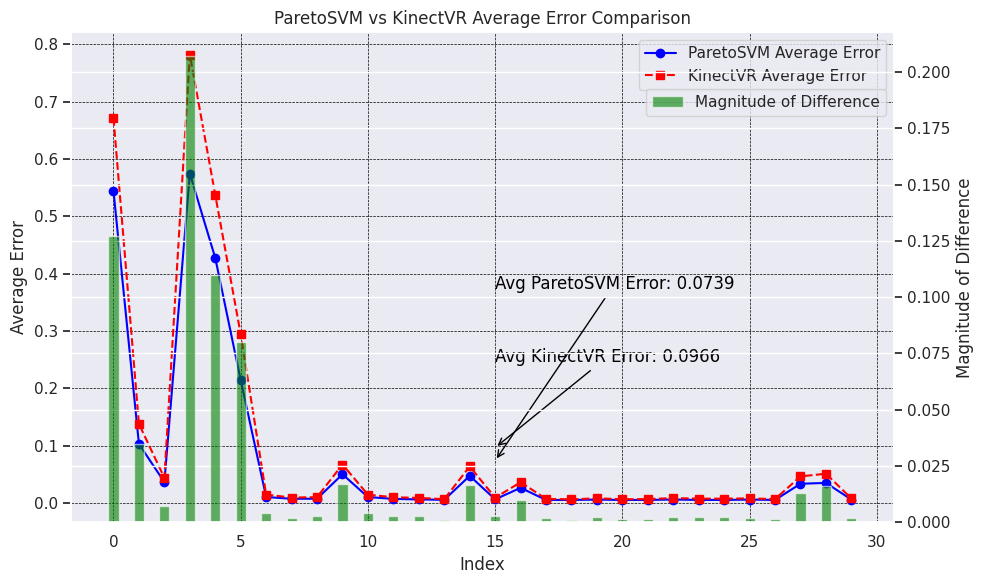

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
pareto_svm = np.array([0.544046, 0.1030735, 0.036547, 0.574539, 0.427272, 0.214288, 0.0105545, 0.007524,
                        0.007632, 0.0502355, 0.010488, 0.007344, 0.006351, 0.005697, 0.047475, 0.006525,
                        0.026622, 0.005427, 0.005427, 0.006102, 0.0054, 0.005454, 0.006215, 0.0055,
                        0.005427, 0.006129, 0.005481, 0.033673, 0.0351575, 0.006156])

kinect_vr = np.array([0.671133561, 0.137983664, 0.043947929, 0.781888544, 0.537056167, 0.294233472,
                        0.014747692, 0.009633096, 0.010363853, 0.067245611, 0.014603491, 0.010197538,
                        0.009009871, 0.00686337, 0.06384915, 0.009363375, 0.036353437, 0.007297382,
                        0.006561497, 0.00829116, 0.00671895, 0.006956075, 0.008730695, 0.007690375,
                        0.007733138, 0.008119397, 0.006961383, 0.046505176, 0.05119275, 0.008044661])

# Compute average error of both models
avg_kinect_vr_error = np.mean(kinect_vr)
avg_pareto_svm_error = np.mean(pareto_svm)

# Create the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the ParetoSVM and KinectVR errors on the first axis
ax1.plot(pareto_svm, marker='o', linestyle='-', color='blue', label='ParetoSVM Average Error')
ax1.plot(kinect_vr, marker='s', linestyle='--', color='red', label='KinectVR Average Error')

# Label the first axis
ax1.set_xlabel('Index')
ax1.set_ylabel('Average Error')
ax1.set_title('ParetoSVM vs KinectVR Average Error Comparison')

# Create a second y-axis for the difference magnitude plot (bar graph)
ax2 = ax1.twinx()

# Calculate the magnitude of the difference (absolute difference)
difference_magnitude = np.abs(kinect_vr - pareto_svm)

# Plot the magnitude of the difference as a bar graph
ax2.bar(np.arange(len(difference_magnitude)), difference_magnitude, width=0.4, color='green', alpha=0.6, label='Magnitude of Difference')

# Label the second axis
ax2.set_ylabel('Magnitude of Difference')

# Set grid color to black
ax1.grid(True, linestyle='--', linewidth=0.5, color='black')

# Annotate the average errors in the middle of the plot
mid_index = len(kinect_vr) // 2
ax1.annotate(f'Avg KinectVR Error: {avg_kinect_vr_error:.4f}',
             xy=(mid_index, avg_kinect_vr_error),
             xytext=(mid_index, avg_kinect_vr_error + 0.15),
             arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
             fontsize=12, color='black')

ax1.annotate(f'Avg ParetoSVM Error: {avg_pareto_svm_error:.4f}',
             xy=(mid_index, avg_pareto_svm_error),
             xytext=(mid_index, avg_pareto_svm_error + 0.3),
             arrowprops=dict(facecolor='black', arrowstyle='->', color='black'),
             fontsize=12, color='black')

# Adjust the legends in the upper-right corner to avoid overlapping
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

# Display the plot
plt.tight_layout()
plt.show()


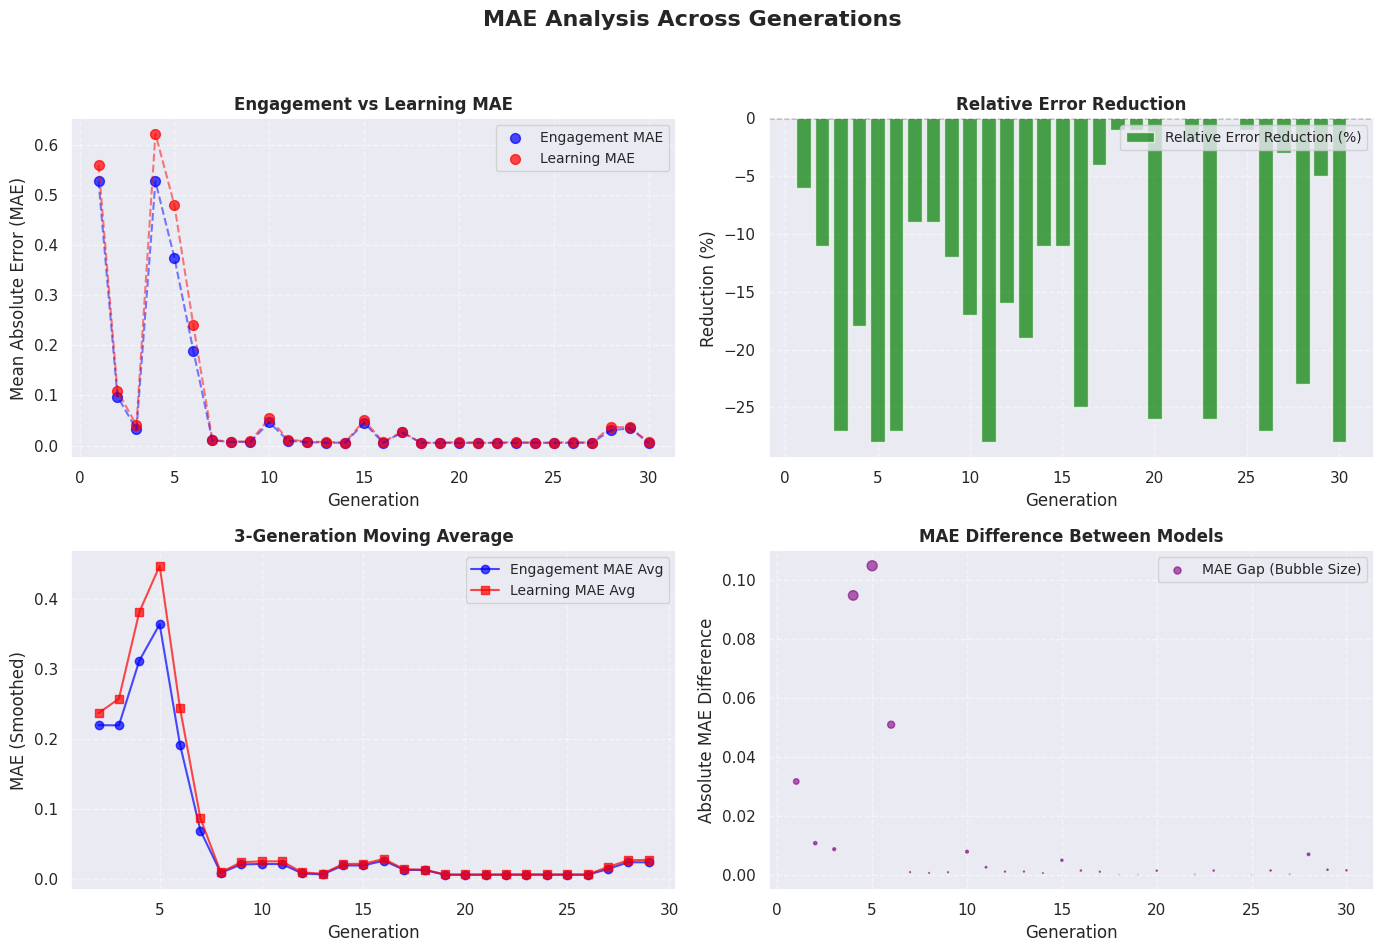

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Given Data
generation = np.arange(1, 31)
engagement_mae = np.array([0.5282, 0.0977, 0.0322, 0.5271, 0.3748, 0.1888, 0.0101, 0.0072, 0.0072, 0.0463,
                            0.0092, 0.0068, 0.0058, 0.0054, 0.045, 0.0058, 0.0261, 0.0054, 0.0054, 0.0054,
                            0.0054, 0.0054, 0.0055, 0.0055, 0.0054, 0.0054, 0.0054, 0.0302, 0.0343, 0.0054])

learning_mae = np.array([0.559892, 0.108447, 0.040894, 0.621978, 0.479744, 0.239776, 0.011009, 0.007848, 0.008064, 0.054171,
                          0.011776, 0.007888, 0.006902, 0.005994, 0.04995, 0.00725, 0.027144, 0.005454, 0.005454, 0.006804,
                          0.0054, 0.005508, 0.00693, 0.0055, 0.005454, 0.006858, 0.005562, 0.037146, 0.036015, 0.006912])

# Calculate New Statistics
mae_gap = np.abs(engagement_mae - learning_mae)
relative_reduction = (engagement_mae - learning_mae) / engagement_mae * 100  # Relative reduction in %
relative_reduction[np.isnan(relative_reduction)] = 0  # Handle division by zero

# Compute Moving Average (Rolling Window of 3)
rolling_avg_engagement = pd.Series(engagement_mae).rolling(window=3, center=True).mean()
rolling_avg_learning = pd.Series(learning_mae).rolling(window=3, center=True).mean()

# Create Subplots (2x2 Grid)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("MAE Analysis Across Generations", fontsize=16, fontweight="bold")

# ======= Subplot 1: Engagement vs Learning MAE =======
ax1 = axes[0, 0]
ax1.scatter(generation, engagement_mae, color='blue', label="Engagement MAE", alpha=0.7, s=50)
ax1.scatter(generation, learning_mae, color='red', label="Learning MAE", alpha=0.7, s=50)
ax1.plot(generation, engagement_mae, linestyle='--', color='blue', alpha=0.5)
ax1.plot(generation, learning_mae, linestyle='--', color='red', alpha=0.5)
ax1.set_title("Engagement vs Learning MAE", fontsize=12, fontweight="bold")
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Absolute Error (MAE)")
ax1.legend(loc="upper right", fontsize=10)
ax1.grid(True, linestyle="--", alpha=0.5)

# ======= Subplot 2: Relative Error Reduction =======
ax2 = axes[0, 1]
bars = ax2.bar(generation, relative_reduction, color='green', alpha=0.7, label="Relative Error Reduction (%)")
ax2.set_title("Relative Error Reduction", fontsize=12, fontweight="bold")
ax2.set_xlabel("Generation")
ax2.set_ylabel("Reduction (%)")
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)  # Baseline
ax2.legend(loc="upper right", fontsize=10)
ax2.grid(True, linestyle="--", alpha=0.5)

# Annotate significant reductions
for bar in bars:
    height = bar.get_height()
    if height > 50:  # Highlight reductions > 50%
        ax2.text(bar.get_x() + bar.get_width()/2, height, f"{height:.1f}%", ha='center', va='bottom', fontsize=9, color='black', fontweight="bold")

# ======= Subplot 3: Moving Average (Smoother Trend) =======
ax3 = axes[1, 0]
ax3.plot(generation, rolling_avg_engagement, linestyle='-', marker='o', color='blue', label="Engagement MAE Avg", alpha=0.7)
ax3.plot(generation, rolling_avg_learning, linestyle='-', marker='s', color='red', label="Learning MAE Avg", alpha=0.7)
ax3.set_title("3-Generation Moving Average", fontsize=12, fontweight="bold")
ax3.set_xlabel("Generation")
ax3.set_ylabel("MAE (Smoothed)")
ax3.legend(loc="upper right", fontsize=10)
ax3.grid(True, linestyle="--", alpha=0.5)

# ======= Subplot 4: Absolute Difference (Gap between MAEs) =======
ax4 = axes[1, 1]
ax4.scatter(generation, mae_gap, color="purple", s=mae_gap * 500, alpha=0.6, label="MAE Gap (Bubble Size)")
ax4.set_title("MAE Difference Between Models", fontsize=12, fontweight="bold")
ax4.set_xlabel("Generation")
ax4.set_ylabel("Absolute MAE Difference")
ax4.legend(loc="upper right", fontsize=10)
ax4.grid(True, linestyle="--", alpha=0.5)

# Adjust Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for the main title
plt.show()


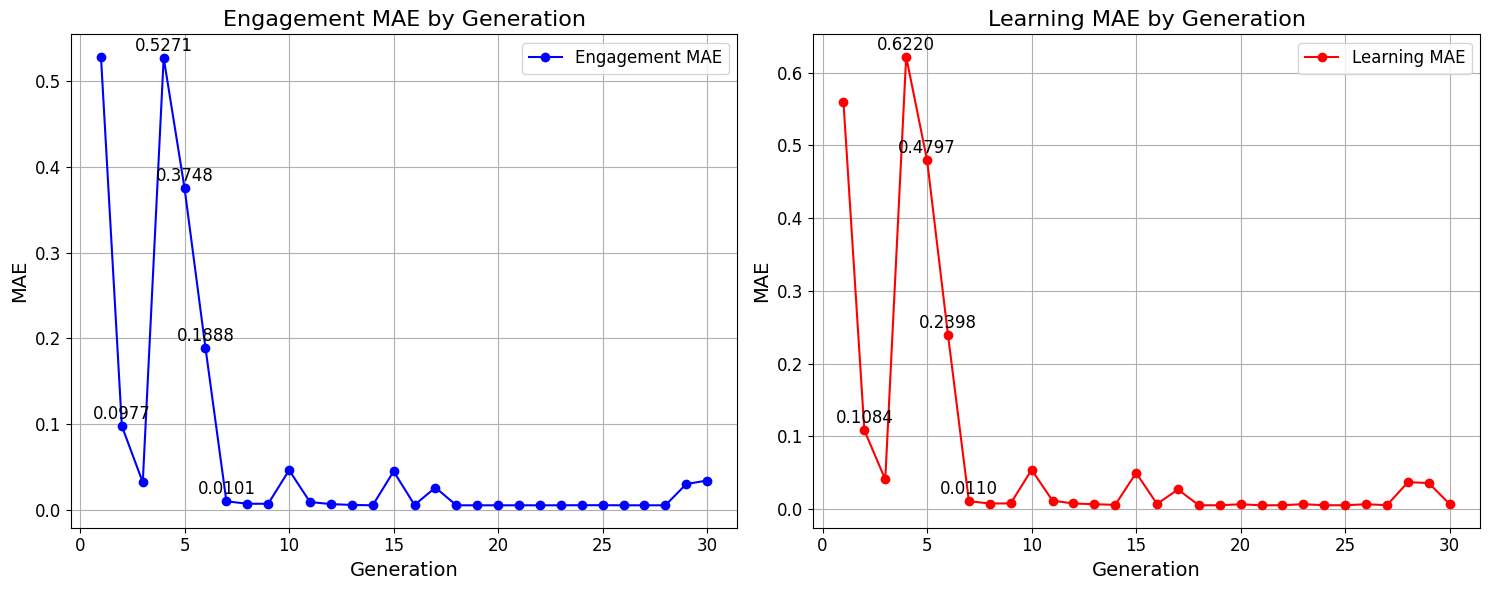

In [ ]:
import matplotlib.pyplot as plt

# Data
generation = list(range(1, 31))  # 30 generations
engagement_mae = [0.5282, 0.0977, 0.0322, 0.5271, 0.3748, 0.1888, 0.0101, 0.0072, 0.0072, 0.0463,
                  0.0092, 0.0068, 0.0058, 0.0054, 0.045, 0.0058, 0.0261, 0.0054, 0.0054, 0.0054,
                  0.0054, 0.0054, 0.0054, 0.0055, 0.0055, 0.0054, 0.0054, 0.0054, 0.0302, 0.0343]
learning_mae = [0.559892, 0.108447, 0.040894, 0.621978, 0.479744, 0.239776, 0.011009, 0.007848, 0.008064,
                0.054171, 0.011776, 0.007888, 0.006902, 0.005994, 0.04995, 0.00725, 0.027144, 0.005454,
                0.005454, 0.006804, 0.0054, 0.005508, 0.00693, 0.0055, 0.005454, 0.006858, 0.005562,
                0.037146, 0.036015, 0.006912]

# Set a threshold for significant difference (e.g., 0.1 for MAE values)
threshold = 0.1

# Increase font sizes
title_size = 16
label_size = 14
tick_size = 12
legend_size = 12
annotation_size = 12

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Engagement MAE Plot
ax[0].plot(generation, engagement_mae, marker='o', color='b', label='Engagement MAE')
ax[0].set_title('Engagement MAE by Generation', fontsize=title_size)
ax[0].set_xlabel('Generation', fontsize=label_size)
ax[0].set_ylabel('MAE', fontsize=label_size)
ax[0].tick_params(axis='both', labelsize=tick_size)
ax[0].grid(True)

# Annotate significantly different points in Engagement MAE plot
for i in range(1, len(engagement_mae)):
    if abs(engagement_mae[i] - engagement_mae[i-1]) > threshold:
        ax[0].annotate(f'{engagement_mae[i]:.4f}', (generation[i], engagement_mae[i]),
                       textcoords="offset points", xytext=(0, 5), ha='center', fontsize=annotation_size)

# Learning MAE Plot
ax[1].plot(generation, learning_mae, marker='o', color='r', label='Learning MAE')
ax[1].set_title('Learning MAE by Generation', fontsize=title_size)
ax[1].set_xlabel('Generation', fontsize=label_size)
ax[1].set_ylabel('MAE', fontsize=label_size)
ax[1].tick_params(axis='both', labelsize=tick_size)
ax[1].grid(True)

# Annotate significantly different points in Learning MAE plot
for i in range(1, len(learning_mae)):
    if abs(learning_mae[i] - learning_mae[i-1]) > threshold:
        ax[1].annotate(f'{learning_mae[i]:.4f}', (generation[i], learning_mae[i]),
                       textcoords="offset points", xytext=(0, 5), ha='center', fontsize=annotation_size)

# Legends
ax[0].legend(fontsize=legend_size)
ax[1].legend(fontsize=legend_size)

# Layout adjustment for better spacing
plt.tight_layout()
plt.show()
